In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

import sys
sys.path.append('..')

from datetime import datetime

from bcb import sgs
from bcb import PTAX
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow
from bizdays import Calendar

from brasa.parsers.b3.futures_settlement_prices import maturity2date
import brasa

In [2]:
man = brasa.CacheManager()
db_folder_path = man.cache_path(man.db_folder())

In [4]:
df = brasa.get_dataset("b3-futures-settlement-prices")

In [3]:
cal = Calendar.load("ANBIMA")
df_contracts = df.to_table().filter(pc.field("commodity") == 'DI1').to_pandas()
df_contracts['maturity_date'] = df_contracts['maturity_code'].apply(lambda x: maturity2date(x, cal))
df_contracts["business_days"] = cal.bizdays(df_contracts['refdate'], cal.following(df_contracts["maturity_date"]))
df_contracts["adjusted_tax"] = (100000 / df_contracts["settlement_price"]) ** (252 / df_contracts["business_days"]) - 1
df_contracts.sort_values(["refdate", "maturity_date"], inplace=True)
df_contracts = df_contracts[["refdate", "symbol", "maturity_date", "settlement_price", "adjusted_tax", "business_days"]]#.query("business_days > 0")

tb_contracts = pyarrow.Table.from_pandas(df_contracts)
ds.write_dataset(tb_contracts, man.db_path("b3-futures-di1"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [4]:
cal = Calendar.load("ANBIMA")
df_contracts = df.filter(pc.field("commodity") == 'DOL').to_table().to_pandas()
df_contracts['maturity_date'] = df_contracts['maturity_code'].apply(lambda x: maturity2date(x, cal))
df_contracts["business_days"] = cal.bizdays(df_contracts['refdate'], cal.following(df_contracts["maturity_date"]))
df_contracts.sort_values(["refdate", "maturity_date"], inplace=True)
df_contracts = df_contracts[["refdate", "symbol", "maturity_date", "settlement_price", "business_days"]]

tb_contracts = pyarrow.Table.from_pandas(df_contracts)
ds.write_dataset(tb_contracts, man.db_path("b3-futures-dol"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [5]:
first = df_contracts.groupby("refdate").nth(0)
second = df_contracts.groupby("refdate").nth(1)
merged = first.merge(second, on="refdate", how="left")
first_contracts = first.copy().reset_index(drop=True)
second_contracts = second.copy().reset_index(drop=True)
first_contracts.loc[merged["business_days_x"] <= 1, :] = second_contracts.loc[merged["business_days_x"] <= 1, :]
first_contracts["ref"] = first_contracts["symbol"]
first_contracts["symbol"] = "DOLT01"
tb_dol_first_contracts = pyarrow.Table.from_pandas(first_contracts)
ds.write_dataset(tb_dol_first_contracts, man.db_path("b3-futures-dol-first-generic"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [6]:
cal = Calendar.load("ANBIMA")
df_contracts = df.filter(pc.field("commodity") == 'DAP').to_table().to_pandas()
df_contracts['maturity_date'] = df_contracts['maturity_code'].apply(lambda x: maturity2date(x, cal, "15th day"))
df_contracts["business_days"] = cal.bizdays(df_contracts['refdate'], cal.following(df_contracts["maturity_date"]))
df_contracts["adjusted_tax"] = (100000 / df_contracts["settlement_price"]) ** (252 / df_contracts["business_days"]) - 1
df_contracts.sort_values(["refdate", "maturity_date"], inplace=True)
df_contracts = df_contracts[["refdate", "symbol", "maturity_date", "settlement_price", "adjusted_tax", "business_days"]]

tb_contracts = pyarrow.Table.from_pandas(df_contracts)
ds.write_dataset(tb_contracts, man.db_path("b3-futures-dap"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [7]:
min_bd = df_contracts.groupby("refdate")["business_days"].transform("min")
df_dap_first_contracts = df_contracts.loc[df_contracts["business_days"] == min_bd,:]

In [8]:
dd = sgs.get({"CDI": 4389}, start=datetime(2000, 1, 1))
dd_cdi = dd.reset_index()
dd_cdi["symbol"] = "CDI"
dd_cdi.columns = ["refdate", "value", "symbol"]

dd = sgs.get({"SELIC": 1178}, start=datetime(2000, 1, 1))
dd_selic = dd.reset_index()
dd_selic["symbol"] = "SELIC"
dd_selic.columns = ["refdate", "value", "symbol"]

dd = sgs.get({"SETA": 432}, start=datetime(2000, 1, 1))
dd_seta = dd.reset_index()
dd_seta["symbol"] = "SETA"
dd_seta.columns = ["refdate", "value", "symbol"]

dd = sgs.get({"IPCA": 433}, start=datetime(1980, 1, 1))
dd_ipca = dd.reset_index()
dd_ipca["symbol"] = "IPCA"
dd_ipca.columns = ["refdate", "value", "symbol"]

dd = sgs.get({"IGPM": 189}, start=datetime(1980, 1, 1))
dd_igpm = dd.reset_index()
dd_igpm["symbol"] = "IGPM"
dd_igpm.columns = ["refdate", "value", "symbol"]

In [9]:

ptax = PTAX()
ep = ptax.get_endpoint('CotacaoMoedaPeriodo')
dd = (ep.query()
   .parameters(moeda='USD', dataInicial='1/1/2000', dataFinalCotacao=datetime.today().strftime("%m/%d/%Y"))
   .filter(ep.tipoBoletim == "Fechamento")
   .select(ep.dataHoraCotacao, ep.cotacaoVenda)
   .collect())
dd_dol = dd
dd_dol["symbol"] = "BRLUSD"
dd_dol.columns = ["value", "refdate", "symbol"]
dd_dol["refdate"] = pd.to_datetime(dd_dol["refdate"])
dd_dol = dd_dol.loc[:, ["refdate", "value", "symbol"]]

In [10]:
dd_dol.dtypes

refdate    datetime64[ns]
value             float64
symbol             object
dtype: object

In [11]:
tb_cdi = pyarrow.Table.from_pandas(dd_cdi)
tb_selic = pyarrow.Table.from_pandas(dd_selic)
tb_seta = pyarrow.Table.from_pandas(dd_seta)
tb_ipca = pyarrow.Table.from_pandas(dd_ipca)
tb_igpm = pyarrow.Table.from_pandas(dd_igpm)
tb_dol = pyarrow.Table.from_pandas(dd_dol)

tb_bcb = pyarrow.concat_tables([tb_cdi, tb_selic, tb_seta, tb_ipca, tb_igpm, tb_dol])

In [12]:
ds.write_dataset(tb_bcb, man.db_path("bcb-data"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [13]:
tb_cotahist_yearly = ds.dataset(f"{db_folder_path}\\b3-cotahist-yearly\\", format="parquet").to_table()
tb_cotahist_daily = ds.dataset(f"{db_folder_path}\\b3-cotahist-daily\\", format="parquet").to_table()
tb_cotahist = pyarrow.concat_tables([tb_cotahist_yearly, tb_cotahist_daily])

tb_cotahist.sort_by([("refdate", "ascending")])
ds.write_dataset(tb_cotahist, man.db_path("b3-cotahist"), format="parquet", existing_data_behavior="overwrite_or_ignore")

<Axes: xlabel='refdate'>

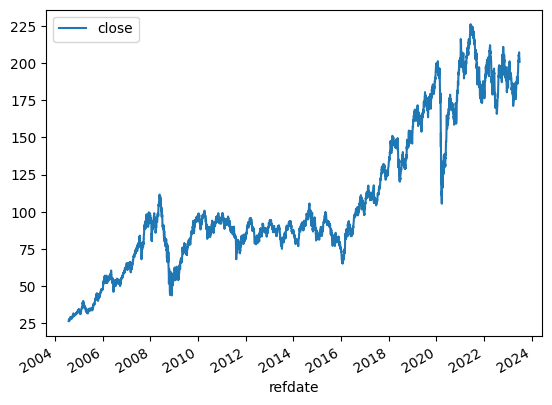

In [14]:
dd = tb_cotahist.filter(pc.field("symbol") == 'PIBB11').to_pandas()
dd.plot(x="refdate", y="close")